In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report

%matplotlib inline

<font size=4>
本文主要参考了以下材料：  
1. cs229: *9.3 softmax regression*  
2. http://ufldl.stanford.edu/wiki/index.php/Softmax%E5%9B%9E%E5%BD%92  
3. https://blog.csdn.net/u012328159/article/details/72155874
</font>

# Softmax Regression
***

## 1. 原理推导

<font size=4>
&emsp;&emsp;Consider a classification problem in which the response variable $y$ can take on any one of $k$ values, so $y\in\{1,\,2,..., k\}$. The response variable is still discrete, but can now take on more than two values. We will thus model it as distributed according to a multinomial distribution.
</font>

<font size=4>
&emsp;&emsp;Lets derive a GLM for modelling this type of multinomial data. To do so, we will begin by expressing the multinomial as an exponential family distribution.
</font>

<font size=4>
&emsp;&emsp;To parameterize a multinomial over $k$ possible outcomes, one could use $k$ parameters $\phi_1,...,\phi_k$ specifying the probability of each of the outcomes. However, these parameters would be redundant, or more formally, they would not be independent (since knowing any $k-1$ of the $\phi_i$'s uniquely determines the last one, as they must satisfy $\sum^{k}_{i=1}\phi_i=1$). So, we will instead parameterize the multinomial with only $k-1$ parameters, $\phi_1,...,\phi_{k-1}$, where $\phi_i=p(y=i;\phi)$, and $p(y=k;\phi)=1-\sum^{k-1}_{i=1}\phi_i$. For notational convenience, we will also let $\phi_k=1-\sum^{k-1}_{i=1}\phi_i$, but we should keep in mind that this is not a parameter, and that it is fully specified by $\phi_1,...,\phi_{k-1}$.
</font>

<font size=4>
&emsp;&emsp;To express the multinomial as an exponential family distribution, we will define $T(y)\in\mathbb{R}^{k-1}$ as follows:
</font>

<font size=4>
$$
T(1)=\begin{bmatrix}1 \\ 0 \\ 0 \\ \vdots \\0\end{bmatrix},
T(2)=\begin{bmatrix}0 \\ 1 \\ 0 \\ \vdots \\0\end{bmatrix},
T(3)=\begin{bmatrix}0 \\ 0 \\ 1 \\ \vdots \\0\end{bmatrix},\cdots,
T(k-1)=\begin{bmatrix}0 \\ 0 \\ 0 \\ \vdots \\1\end{bmatrix},
T(k)=\begin{bmatrix}0 \\ 0 \\ 0 \\ \vdots \\0\end{bmatrix},
$$
</font>

<font size=4>
&emsp;&emsp;Unlike our previous examples, here we do not have $T(y)=y$; also, $T(y)$ is now a $k-1$ dimensional vector, rather than a real number. We will write $(T(y))_i$ to denote the $i$-th element of the vector $T(y)$. 
</font>

<font size=4>
&emsp;&emsp;We introduce one more very useful piece of notation. An indicator function $1\{\cdot\}$ takes on a value of 1 if its argument is true, and 0 otherwise. So, we can write the relationship between $T(y)$ and $y$ as $(T(y))_i=1\{y=i\}$&ensp;(当且仅当$y=i$时，向量$T(y)$的第$i$个位置元素为1). Further, we have that $E[(T(y))_i]=P(y=i)=\phi_i$.
</font>

<font size=4>
&emsp;&emsp;We are now ready to show that the multinomial is a member of the exponential family. We have:
</font>

<font size=4>
$$
\begin{align}
p(y;\phi) &= \phi_1^{1\{y=1\}}\phi_2^{1\{y=2\}}\cdots\phi_k^{1\{y=k\}} \\
&= \phi_1^{1\{y=1\}}\phi_2^{1\{y=1\}}\cdots\phi_k^{1-\sum^{k-1}_{i=1}1\{y=i\}} \\
&= \phi_1^{(T(y))_1}\phi_2^{(T(y))_2}\cdots\phi_k^{1-\sum^{k-1}_{i=1}(T(y))_i} \\
&= exp((T(y))_1log(\phi_1)+(T(y))_2log(\phi_2)+\cdots+(1-\sum^{k-1}_{i=1}(T(y))_i)log(\phi_k)) \\
&= exp((T(y))_1log(\frac{\phi_1}{\phi_k})+(T(y))_2log(\frac{\phi_2}{\phi_k})+\cdots+(T(y))_{k-1}log(\frac{\phi_{k-1}}{\phi_k})+log(\phi_k)) \\
&= b(y)\,exp(\eta^TT(y)-a(\eta))
\end{align}
$$
</font>

<font size=4>
&emsp;&emsp;where
</font>

<font size=4>
$$
\eta=\begin{bmatrix} log(\frac{\phi_1}{\phi_k}) \\ log(\frac{\phi_2}{\phi_k}) \\ \vdots \\ log(\frac{\phi_{k-1}}{\phi_k}) \end{bmatrix}
$$
</font>

<font size=4>
$$a(\eta) = -log(\phi_k)$$
</font>

<font size=4>
$$b(y)=1$$
</font>

<font size=4>
&emsp;&emsp;This completes our formulation of the multinomial as an exponential family distribution.
</font>

<font size=4>
&emsp;&emsp;The link function is given (for $i=1,\cdots,k$) by
</font>

<font size=4>
$$
\eta_i=log\frac{\phi_i}{\phi_k}
$$
</font>

<font size=4>
&emsp;&emsp;For convenience, we have also defined $\eta_k=log(\frac{\phi_k}{\phi_k})=0$. To invert the link function and derive the response function, we therefore have that
</font>

<font size=4>
$$
e^{\eta_i}=\frac{\phi_i}{\phi_k}
$$
</font>

<font size=4>
$$
\phi_ke^{\eta_i}=\phi_i\quad-(1)
$$
</font>

<font size=4>
$$
\phi_k\sum_{i=1}^{k}e^{\eta_i}=\sum_{i=1}^{k}\phi_i=1
$$
</font>

<font size=4>
&emsp;&emsp;This implies that $\phi_k={1}/{\sum_{i=1}^{k}e^{\eta_i}}$, which can be substituted back into Equation (1) to give the response function

<font size=4>
$$
\phi_i=\frac{e^{\eta_i}}{\sum_{l=1}^{k}e^{\eta_l}}
$$
</font>

<font size=4>
&emsp;&emsp;This function mapping from the $\eta$'s to the $\phi$'s is called the **softmax function**.
</font>

<font size=4>
&emsp;&emsp;To complete our model, we use Assumption 3, given earlier, that the $\eta$'s are linearly related to the $x$'s. So, have $\eta_i=\theta^T_ix$ (for $i\ =\ 1,\cdots,k-1$), where $\theta_1,\cdots,\theta_{k-1}\in\mathbb{R}^{n+1}$ are the parameters of our model. For notational convenience, we can also define $\theta_k=0$, so that $\eta_k=\theta_k^Tx=0$, as given previously. Hence, our model assumes that the conditional distribution of $y$ given $x$ is given by
</font>

<font size=4>
$$
\begin{align}
p(y=i|x;\theta) &= \phi_i \\
&= \frac{e^{\eta_i}}{\sum_{l=1}^{k}e^{\eta_l}} \\
&= \frac{e^{\theta^T_ix}}{\sum_{l=1}^{k}e^{\theta^T_lx}} \quad-(2)
\end{align}
$$
</font>

<font size=4>
&emsp;&emsp;This model, which applies to classification problems where $y\in\{1,\cdots,k\}$, is called **softmax regression**. It is a generalization of logistic regression.
</font>

<font size=4>
&emsp;&emsp;Our hypothesis will output
</font>

<font size=4>
$$
\begin{align}
h_\theta(x) &= E[T(y)\,|\,x;\theta] \\
&= E\left[ {\begin{array}{c|c}\begin{matrix} 1\{y=1\} \\ 1\{y=2\} \\ \cdots \\ 1\{y=k-1\} \end{matrix}&\begin{matrix} \\ \\ x;\theta \\ \\ \end{matrix}\end{array}} \right] \\
&= \begin{bmatrix} \phi_1 \\ \phi_2 \\ \cdots \\ \phi_{k-1} \end{bmatrix} \\
&= \begin{bmatrix} \frac{exp(\theta^T_1x)}{\sum^{k}_{l=1}exp(\theta^T_lx)} \\ \frac{exp(\theta^T_2x)}{\sum^{k}_{l=1}exp(\theta^T_lx)} \\ \vdots \\ \frac{exp(\theta^T_{k-1}x)}{\sum^{k}_{l=1}exp(\theta^T_lx)} \end{bmatrix}
\end{align}
$$
</font>

<font size=4>
&emsp;&emsp;In other words, our hypothesis will output the estimated probability that $p(y=i|x;\theta)$, for every value of $i=1,\cdots,k$.(Even though $h_\theta(x)$ as defined above is only $k-1$ dimensional, clearly $p(y=k|x;\theta)$ can be obtained as $1-\sum^{k-1}_{i=1}\phi_i$.)
</font>

<font size=4>
&emsp;&emsp;Lastly, lets discuss parameter fitting. Similar to our original derivation of ordinary least squares and logistic regression, if we have a training set of $m$ examples $\{(x^{(i)},y^{(i)});i=1,\cdots,m\}$ and would like to learn the parameter $\theta_i$ of this model, we would begin by writing down the log-likelihood:
</font>

<font size=4>
$$
\begin{align}
l(\theta) &= \sum^{m}_{i=1}logp(y^{(i)}|x^{(i)};\theta) \\
&= \sum^{m}_{i=1}log\prod^{k}_{j=1}\left( \frac{e^{\theta^T_jx^{(i)}}}{\sum^{k}_{i=l}e^{\theta^T_lx^{(i)}}} \right)^{1\{y^{(i)}=j\}} \\
&= \sum^{m}_{i=1}\sum^{k}_{j=1}1\{y^{(i)}=j\}log\frac{e^{\theta^T_jx^{(i)}}}{\sum^{k}_{l=1}e^{\theta^T_lx^{(i)}}}
\end{align} 
$$
</font>

<font size=4>
&emsp;&emsp;To obtain the second line above, we used the definition for $p(y|x;\theta)$ given in Equation (2). We can now obtain the maximum likelihood estimate of the parameters by maximizing $l(\theta)$ in terms of $\theta$, using a method such as gradient ascent or Newton's method.
</font>

## 2. 梯度下降法

### 2.1 Cost Function

<font size=4>
&emsp;&emsp;首先，定义
</font>

<font size=4>
$$
x^{(i)}=\begin{bmatrix} x^{(i)}_0 \\ x^{(i)}_1 \\ \vdots \\ x^{(i)}_{n+1} \end{bmatrix}_{(n+1)×1} \quad
X=\begin{bmatrix} -(x^{(1)})^T- \\ -(x^{(2)})^T- \\ \cdots \\ -(x^{(m)})^T- \end{bmatrix}_{m×(n+1)} \quad
\theta=\begin{bmatrix} -\theta^T_1- \\ -\theta^T_2- \\ \cdots \\ -\theta^T_k- \end{bmatrix}_{k×(n+1)}
$$
</font>

<font size=4>
&emsp;&emsp;注意到，$x^{(i)}\in\mathbb{R}^{n+1}$，其中定义$x^{(i)}_0=0$。然后，$\theta_1,\theta_2,\cdots,\theta_k\in\mathbb{R}^{n+1}$，在这里，我没有定义$\theta_k=0$，因此，存在过度参数化的问题。所以，在接下来的小节内会对这个问题进行解决。最后，$y\in\{1,2,\cdots,k\}$。
</font>

<font size=4>
&emsp;&emsp;因此，我们定义Cost Function为
</font>

<font size=4>
$$
J(\theta)=-\frac{1}{m}\left( \sum^{m}_{i=1}\sum^{k}_{j=1}1\{y^{(i)}=j\}log\frac{e^{\theta^T_jx^{(i)}}}{\sum^{k}_{l=1}e^{\theta^T_l}x} \right)
$$
</font>

<font size=4>
&emsp;&emsp;值得注意的是，上述公式是逻辑回归的cost function的推广，逻辑回归的cost function可以改为：
</font>

<font size=4>
$$
\begin{align}
J(\theta) &= -\frac{1}{m} \left( \sum^{m}_{i=1}(1-y^{(i)})log(1-h_\theta(x^{(i)}))+y^{(i)}logh_\theta(x^{(i)}) \right) \\
&= -\frac{1}{m}\left( \sum^{m}_{i=1}\sum^{1}_{j=0}1\{y^{(i)}=j\}log\,p(y^{(i)}=j\,|\,x^{(i)};\theta) \right)
\end{align}
$$
</font>

### 2.2 Softmax Regression 模型参数化的特点

<font size=4>
&emsp;&emsp;由于上一节，我们没有定义 $\theta_k=0$，这使得softmax regression有一个“冗余”的参数集。虽然，定义 $\theta_k=0$ 可以避免这个问题，但是这会使得在算法实现中没有那么简单清楚，而且，这个问题是可以得到解决的。接下来，我们对这个问题进行具体说明。
</font>

<font size=4>
&emsp;&emsp;假设我们从参数向量 $\theta_j$ 中减去了向量 $\psi$，这时，每一个 $\theta_j$ 都变成了 $\theta_j-\psi \ (j=1,\cdots,k)$。此时假设函数变成了以下的式子：
</font>

<font size=4>
$$
\begin{align}
p(y^{(i)}=j\,|\,x^{(i)};\theta)
&= \frac{e^{(\theta_j-\psi)^Tx^{(i)}}}{\sum^{k}_{l=1}e^{(\theta_l-\psi)^Tx^{(i)}}} \\ 
& = \frac{e^{\theta^T_jx^{(i)}}e^{-\psi^Tx^{(i)}}}{\sum^{k}_{l=1}e^{\theta_l^Tx^{(i)}}e^{-\psi^Tx^{(i)}}} \\
&= \frac{e^{\theta_j^Tx^{(i)}}}{\sum^{k}_{l=1}e^{\theta_l^T}x^{(i)}}
\end{align}
$$
</font>

<font size=4>
&emsp;&emsp;换句话说，从 $\theta_j$ 中减去 $\psi$ 完全不影响假设函数的预测结果。这表明前面的softmax regression模型中存在冗余的参数。更正式一点说，softmax regression模型被过度参数化了。对于任意一个用于拟合数据的假设函数，可以求出多组参数值，这些参数得到的是完全相同的假设函数 $h_\theta$。
</font>

<font size=4>
&emsp;&emsp;进一步而言，如果参数 $(\theta_1,\theta_2,\cdots,\theta_k)$ 是 cost function $J(\theta)$ 的极小值点，那么 $(\theta_1-\psi,\theta_2-\psi,\cdots,\theta_k-\psi)$ 同样也是它的极小值点，其中 $\psi$ 可以为任意向量。因此，使得 $J(\theta)$ 最小化的解不是唯一的。（有趣的是，由于 $J(\theta)$仍然是一个凸函数，因此梯度下降不会遇到局部最优解的问题，但是 $Hessian$ 矩阵是奇异的/不可逆的，这会直接导致采用牛顿法优化就遇到数值计算的问题）
</font>

<font size=4>
&emsp;&emsp;注意，当 $\phi=\theta_k$ 时，我们总是可以将 $\theta_k$ 替换为 $\theta_k-\psi=\vec{0}$（即替换为全零向量），并且这种替换不会影响假设函数。因此，我们可以去掉参数向量 $\theta_k$ （或者其他 $\theta_j$ 中的任意一个）而不影响假设函数的表达能力。实际上，与其优化全部的 $k×(n+1)$ 个参数 $(\theta_1,\theta_2,\cdots,\theta_k)$ （其中，$\theta_j\in\mathbb{R}^{n+1}$），我们可以令 $\theta_k=\vec{0}$，只优化剩余的 $(k-1)×(n+1)$ 个参数，这样算法依然能够正常工作。
</font>

<font size=4>
&emsp;&emsp;在实际应用中，为了让算法实现更加简单清楚，往往保留所有参数 $(\theta_1,\theta_2,\cdots,\theta_k)$，而不任意地将某一参数设置为 $\vec{0}$。但此时，我们需要对 cost function 做一个改动：加入权重衰减项。权重衰减项可以解决 softmax regression 参数冗余所带来的数值问题。
</font>

### 2.3 权重衰减

<font size=4>
&emsp;&emsp;我们通过添加一个权重衰减项 $\frac{\lambda}{2}\sum^{k}_{i=1}\sum^{n}_{j=0}\theta_{ij}^2$ 来修改 cost function，这个衰减项会惩罚过大的参数值，现在我们的 cost function 变为：
</font>

<font size=4>
$$
J(\theta)=-\frac{1}{m}\left( \sum^{m}_{i=1}\sum^{k}_{j=1}1\{y^{(i)}=j\}\,log\,\frac{e^{\theta_j^Tx^{(i)}}}{\sum^{k}_{l=1}e^{\theta^T_lx^{(i)}}} \right)+\frac{\lambda}{2}\sum^{k}_{i=1}\sum^{n}_{j=0}\theta_{ij}^2
$$
</font>

<font size=4>
&emsp;&emsp;有了这个权重衰减项之后($\lambda>0$)，Cost function 就变成了严格的凸函数，这样就可以保证得到唯一的解了。此时的 Hessian 矩阵变成可逆矩阵，并且因为 $J(\theta)$ 是凸函数，梯度下降法和L-BFGS等算法可以保证收敛到全局最优解。
</font>

<font size=4>
&emsp;&emsp;为了使用优化算法，我们需要求得这个新函数的 $J(\theta)$ 的导数，如下：
</font>

<font size=4>
$$
\triangledown_{\theta_j}J(\theta)=-\frac{1}{m}\left( x^{(i)}(1\{y^{(i)}=j\}-p(y^{(i)}\,|\,x^{(i)};\theta)) \right)+\lambda\theta_j
$$
</font>

<font size=4>
&emsp;&emsp;注意，这里的 $\triangledown_{\theta_j}J(\theta)\in\mathbb{R}^{n+1}$。通过最小化 $J(\theta)$，我们就能实现一个可用的 softmax regression 模型。
</font>

### 2.4 推导 $\frac{\partial{J(\theta)}}{\partial\theta_j}$

<font size=4>
&emsp;&emsp;方法一：
</font>

<font size=4>
$$
\begin{align}
\frac{\partial{J(\theta)}}{\partial\theta_j}
&= -\frac{1}{m}\frac{\partial}{\partial\theta_j}\left[ \sum^{m}_{i=1}\sum^{k}_{j=1}1\{y^{(i)}=j\}\,log\,\frac{e^{\theta_j^Tx^{(i)}}}{\sum^{k}_{l=1}e^{\theta_l^Tx^{(i)}}} \right]+\lambda\theta_j \\
&= -\frac{1}{m}\frac{\partial}{\partial\theta_j}\left[ \sum^{m}_{i=1}\sum^{k}_{j=1}1\{y^{(i)}=j\}\,(log\,e^{\theta_j^Tx^{(i)}}-log\,\sum^{k}_{l=1}e^{\theta_l^Tx^{(i)}}) \right]+\lambda\theta_j \\
&= -\frac{1}{m}\frac{\partial}{\partial\theta_j}\left[ \sum^{m}_{i=1}\sum^{k}_{j=1}1\{y^{(i)}=j\}\,(\theta_j^Tx^{(i)}-log\,\sum^{k}_{l=1}e^{\theta_l^Tx^{(i)}}) \right]+\lambda\theta_j \\
&= -\frac{1}{m}\frac{\partial}{\partial\theta_j}\left[ \sum^{m}_{i=1}1\{y^{(i)}=j\}\,(\sum^{k}_{j=1}\theta_j^Tx^{(i)}-\sum^{k}_{j=1}log\,\sum^{k}_{l=1}e^{\theta_l^Tx^{(i)}}) \right]+\lambda\theta_j \\
&= -\frac{1}{m}\left[ \sum^{m}_{i=1}1\{y^{(i)}=j\}\,(x^{(i)}-\sum^{k}_{j=1}\frac{x^{(i)}e^{\theta_j^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}}) \right]+\lambda\theta_j \\
&= -\frac{1}{m}\left[ \sum^{m}_{i=1}x^{(i)}\,(1\{y^{(i)}=j\}-\sum^{k}_{j=1}1\{y^{(i)}=j\}\frac{e^{\theta_j^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}}) \right]+\lambda\theta_j \\
&= -\frac{1}{m}\left[ \sum^{m}_{i=1}x^{(i)}\,(1\{y^{(i)}=j\}-\frac{e^{\theta_j^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}}) \right]+\lambda\theta_j \\
&= -\frac{1}{m}\left[ \sum^{m}_{i=1}x^{(i)}\,(1\{y^{(i)}=j\}-p(y^{(i)}\,|\,x^{(i)};\theta)) \right]+\lambda\theta_j
\end{align} 
$$
</font>

<font size=4>
&emsp;&emsp;方法二：
</font>

<font size=4>
$$
\begin{align}
\frac{\partial{J(\theta)}}{\partial\theta_j}
&= -\frac{1}{m}\left[ \sum^{m}_{i=1}\frac{\partial}{\partial{\theta_j}}(1\{y^{(i)}=j\}\,log\,\frac{e^{\theta_j^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}}+\sum^k_{c\ne{j}}1\{y^{(i)}=c\}\,log\,\frac{e^{\theta_c^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}}) \right]+\lambda\theta_j \\ 
&= -\frac{1}{m}\left[ \sum^{m}_{i=1}(1\{y^{(i)}=j\}(x^{(i)}-\frac{x^{(i)}e^{\theta_j^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}})+\sum^k_{c\ne{j}}1\{y^{(i)}=c\}(-\frac{x^{(i)}e^{\theta_j^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}})) \right]+\lambda\theta_j \\
&= -\frac{1}{m}\left[ \sum^{m}_{i=1}(x^{(i)}1\{y^{(i)}=j\}(1-\frac{e^{\theta_j^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}})+\sum^k_{c\ne{j}}1\{y^{(i)}=c\}(-\frac{x^{(i)}e^{\theta_j^Tx^{(i)}}}{\sum^k_{l=1}e^{\theta_l^Tx^{(i)}}})) \right]+\lambda\theta_j \\
&= \frac{1}{m}\left[ \sum^m_{i=1}x^{(i)}(1\{y^{(i)}=j\}-1\{y^{(i)}=j\}p(y^{(i)}\,|\,x^{(i)};\theta))+\sum^k_{c\ne{j}}1\{y^{(i)}=c\}(-p(y^{(i)}\,|\,x^{(i)};\theta)) \right]+\lambda\theta_j \\
&= \frac{1}{m}\left[ \sum^m_{i=1}x^{(i)}(1\{y^{(i)}=j\}-\sum^k_{j=1}1\{y^{(i)}=j\}p(y^{(i)}\,|\,x^{(i)};\theta) \right]+\lambda\theta_j \\
&= -\frac{1}{m}\left[ \sum^{m}_{i=1}x^{(i)}\,(1\{y^{(i)}=j\}-p(y^{(i)}\,|\,x^{(i)};\theta)) \right]+\lambda\theta_j
\end{align}
$$
</font>

### 2.5 矩阵化

<font size=4>
&emsp;&emsp;因为 $y\in\{1,2,\cdots,k\}$，所以，对 $y$ 进行独热编码。即 $y^{(i)}\in\mathbb{R}^{k}$，其中，若 $y^{(i)}$ 属于类别 $i$，则 $y^{(i)}$ 第 $i$ 个位置上的元素为1，其余位置元素为0。因此，定义矩阵 $G$ 为
</font>

<font size=4>
$$
G=
\begin{bmatrix}
-(y^{(1)})^T- \\ -(y^{(2)})^T- \\ \vdots \\ -(y^{(m)})^T-
\end{bmatrix}_{m×k}
$$
</font>

<font size=4>
&emsp;&emsp;定义概率矩阵 $P$ 为
</font>

<font size=4>
$$
P_{m×k} = norm(\,exp(X_{m×(n+1)}\cdot\theta_{(n+1)×k}^T)\,)\quad
$$
</font>

<font size=4>
&emsp;&emsp;其中，norm 表示归一化项，因此，概率矩阵 $P$ 的具体计算方式为：首先，计算 $exp(X\theta^T)$ 得到 $m×k$ 的矩阵。其次，使用 $np.sum()$ 对该该矩阵按行进行求和，得到 m×1 的矩阵。最后，利用Python的广播（broadcast）机制，将该矩阵与 $exp(X\theta^T)$ 对应位置元素进行相乘（element-wise multiplication）得到概率矩阵 $P$。
</font>

<font size=4>
&emsp;&emsp;于是
</font>

<font size=4>
$$
\frac{\partial{J(\theta)}}{\partial\theta}
=-\frac{1}{m}(G-P)^T\cdot{X}+\lambda\theta
$$
</font>

<font size=4>
&emsp;&emsp;所以，cost function为
</font>

<font size=4>
$$
J(\theta)=-np.mean(G\circ{P})+\lambda \ {np.sum(\theta)}
$$
</font>

<font size=4>
&emsp;&emsp;其中，$\circ$ 表示对应位置元素相乘，即 element-wise multiplication。
</font>

## 3. 实现 softmax regression

### 3.1 读取数据

In [2]:
iris = load_iris()
features = pd.DataFrame(data=iris.data, columns=iris.feature_names)
label = pd.DataFrame(data=iris.target, columns=['traget'])
data = pd.concat([features, label], axis=1)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),traget
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
def loadData(df):
    ones = pd.DataFrame({'ones': np.ones(len(df))})
    df = pd.concat([ones, df], axis=1)
    X = df.iloc[:,:-1].values
    y = df.iloc[:,-1].values
    return X, y

In [4]:
X, y = loadData(data)
X.shape, y.shape

((150, 5), (150,))

### 3.2 数据可视化

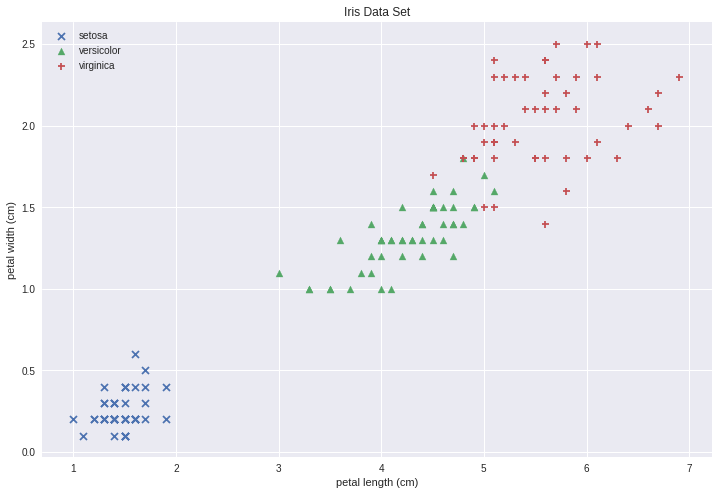

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 3][y==0], X[:, 4][y==0], marker='x', label=iris.target_names[0])
plt.scatter(X[:, 3][y==1], X[:, 4][y==1], marker='^', label=iris.target_names[1])
plt.scatter(X[:, 3][y==2], X[:, 4][y==2], marker='+', label=iris.target_names[2])
plt.legend(loc='upper left')
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.title('Iris Data Set')
plt.show()

### 3.3 Softmax Regression

<font size=4>
&emsp;&emsp;对 $y$ 进行独热编码，得到矩阵G。
</font>

In [6]:
def oneHotY(y):
    # m为样本数
    m = y.shape[0]
    # k为类别数
    k = len(np.unique(y))
    
    oneHotY = np.zeros((m, k))
    for i in range(k):
        oneHotY[:, i] = (y==i)
        
    return oneHotY

In [7]:
G = oneHotY(y)
G.shape

(150, 3)

In [8]:
def initializeWithZeros(X, y):
    k = len(np.unique(y))
    
    return np.zeros((k, X.shape[1]))

In [9]:
def probabilityMatrix(X, theta):
    expScore = np.exp(X @ theta.T)
    sumScore = np.sum(expScore, axis=1).reshape(-1, 1)
    
    return np.multiply(expScore, sumScore)

In [10]:
def computeCost(X, G, theta, l):
    P = probabilityMatrix(X, theta)
    return -np.mean(np.multiply(G, np.log(P))) + l * theta.sum()

In [11]:
def computeGradient(X, G, theta, l):
    m = X.shape[0]
    P = probabilityMatrix(X, theta)
    grad = -((G-P).T @ X) / m + l *theta
    
    return grad

In [12]:
def batchGradientDescent(X, G, theta, alpha, iters, l, printFlag=True):
    costs = np.zeros(iters)
    
    for i in range(iters):
        theta = theta - alpha * computeGradient(X, G, theta, l)
        costs[i] = computeCost(X, G, theta, l)
        
        if printFlag and i % 1000 == 0:
            print(costs[i])
        
    return theta, costs

In [13]:
def predict(X, theta):
    P = probabilityMatrix(X, theta)
    
    return np.argmax(P, axis=1).reshape(-1, 1)

In [14]:
X, y = loadData(data)
G = oneHotY(y)
theta = initializeWithZeros(X, y)

iters = 10000
alpha = 0.01
l = 0.1

theta, costs = batchGradientDescent(X, G, theta, alpha, iters, l)

0.577650282651
0.0685942497214
0.062683569659
0.0612484292857
0.0608645968918
0.0607601270249
0.060731296824
0.0607232213633
0.0607209225948
0.0607202570216


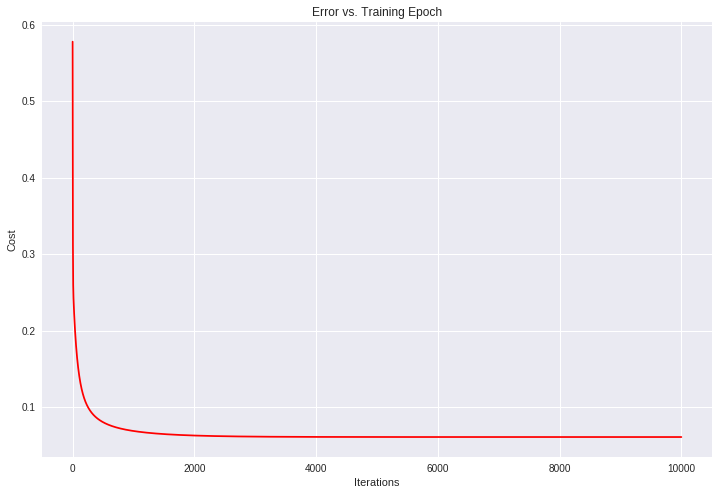

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(iters), costs, color='red')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Error vs. Training Epoch')
plt.show()

In [16]:
y_pred = predict(X, theta)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.80      0.89        50
          2       0.83      1.00      0.91        50

avg / total       0.94      0.93      0.93       150



## 4. Softmax Regression 与 Logistic Regression 的关系

<font size=4>
&emsp;&emsp;当类别数 $k=2$ 时，softmax regression 退化为 logistic regression。这表明 softmax regression 是 logistic regression 的一般形式。具体地说，当 $k=2$ 时，softmax regression 的假设函数为：
</font>

<font size=4>
$$
h_\theta(x)=\frac{1}{e^{\theta_1^Tx}+e^{\theta_2^T}x}
\begin{bmatrix}
e^{\theta_1^Tx} \\
e^{\theta_2^Tx}
\end{bmatrix}
$$
</font>

<font size=4>
&emsp;&emsp;利用 softmax regression 回归参数冗余的特点，我们令 $\psi=\theta_1$，并且从两个参数向量中都减去向量 $\theta_1$，得到：
</font>

<font size=4>
$$
\begin{align}
h(x) &= \frac{1}{e^{\vec{0}^Tx}+e^{(\theta_2-\theta_1)^Tx}}
\begin{bmatrix}
e^{\vec{0}^Tx} \\
e^{(\theta_1-\theta_2)^Tx}
\end{bmatrix} \\
&= 
\begin{bmatrix}
\frac{1}{1+e^{(\theta_1-\theta_2)^Tx}} \\
\frac{e^{(\theta_1-\theta_2)^Tx}}{1+e^{(\theta_1-\theta_2)^Tx}}
\end{bmatrix} \\
&=
\begin{bmatrix}
\frac{1}{1+e^{(\theta_1-\theta_2)^Tx}} \\
1-\frac{1}{1+e^{(\theta_1-\theta_2)^Tx}}
\end{bmatrix} 
\end{align}
$$
</font>

<font size=4>
&emsp;&emsp;因此，用 $\theta'$ 来表示 $\theta_1-\theta_2$，我们就会发现 softmax regression 预测其中一个类别的概率为 $\frac{1}{1+e^{(\theta')^Tx}}$，另一个类别的概率为 $1-\frac{1}{1+e^{(\theta')^Tx}}$，这与logistic regression 是一致的。
</font>

## 5. Softmax Regression vs. k 个二元分类器

<font size=4>
&emsp;&emsp;如果你在开发一个音乐分类的应用，需要对 $k$ 种类型的音乐进行识别，那么是选择使用 softmax regression，还是使用 logistic regression 建立 $k$ 个独立的二元分类器呢？
</font>

<font size=4>
&emsp;&emsp;这一选择取决于你的类别之间是否互斥，例如，如果你有四个类别的音乐，分别为：古典音乐、乡村音乐、摇滚乐和爵士乐，那么你可以假设每个训练样本只会被打上一个标签（即一首歌只能属于这四种音乐类型的其中一种），此时，你应该使用类别数 $k=4$ 的 softmax regression（如果在你的数据集中，有的歌曲不属于以上四类的其中任何一类，那么你可以添加一个”其他类“，并将类别数 $k$ 设为5）。
</font>

<font size=4>
&emsp;&emsp;如果你的四个类别如下：人声音乐、舞曲、影视原声、流行歌曲，那么这些类别之间并不是互斥的。例如：一首歌曲可以来源于影视原声，同时也包含人声。在这种情况下，使用4个二分类的 logistic regression 更为合适。这样每个新的音乐作品，我们的算法可以分别判断它是否属于各个类别。
</font>

<font size=4>
&emsp;&emsp;现在，我们来看一个计算机视觉领域的例子，你的任务是将图像分到三个不同的类别中。（1）假设这三个类别分别是：室内场景、户外城区场景、户外荒野场景。你会使用softmax regression 还是3个 logistic regression 呢？（2）现在假设这三个类别分别是室内场景、黑白图片、包含人物的图片，你会选择 softmax regression 还是多个 logistic regression 呢？
</font>

<font size=4>
&emsp;&emsp;在第一个例子中，三个类别是互斥的，因此，更适于选择 softmax regression。而在第二个例子中，建立三个独立的 logistic regression 更加合适。
</font>